## 1. Model Selection.
    - XGBoost
    - LightGBM (Microsoft)
    - CNTK (Microsoft)
    - Leaf (https://github.com/autumnai/leaf)
    - ExtraTreesClassifier

In [1]:
import warnings
import numpy as np
import scipy as sp
import pandas as pd
#import sklearn as skl
import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint as sp_randint
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
import seaborn as sns
#import xgboost as xgb
#import lightgbm as lgb
import pickle
import gzip
%pylab inline
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
def run_cv(X, y, clf, num_iters):

    # Construct a kfolds object:
    # For softprob prediction this will only work if the distribution of 
    # label values is even throughout each sub-sample, so only large sample
    # sizes will generally work, small sample sizes with a large number of
    # label values will generate errors when doing the softprob assignment
    # to y_prob because the training set will likely have a different number
    # of unique label values from the full sample set.
    # In this case comment out the softprob assignment and y_prob return
    # value.
    
    len_y = len(y)
    num_labels = y.nunique()
    
    kf = KFold(n_splits=num_iters, shuffle=True)
    y_prob = np.zeros((len_y, num_labels))
    y_pred = np.zeros(len_y)
    
    # Iterate through folds
    for train_index, test_index in kf.split(X,y):
        print(test_index, train_index)
        X_train = X.loc[train_index,:]
        X_test = X.loc[test_index,:]
        y_train = y[train_index]

        clf.fit(X_train, y_train) # use flatten to get rid of data conversion warnings
        
        y_prob[test_index] = clf.predict_proba(X_test)
        y_pred[test_index] = clf.predict(X_test)
        #print(clf.get_params())
    
    return y_prob, y_pred


def print_classification_report(y, y_pred, out_file):
    fop = open('data/' + out_file, 'w')
    outlines = classification_report(y, y_pred)
    fop.writelines(outlines)
    fop.close()
    
    return
    

def run_prediction_cv(X, y, clf, num_iters):

    # Construct a kfolds object:
    # For softprob prediction this will only work if the distribution of 
    # label values is even throughout each sub-sample, so only large sample
    # sizes will generally work, small sample sizes with a large number of
    # label values will generate errors when doing the softprob assignment
    # to y_prob because the training set will likely have a different number
    # of unique label values from the full sample set.
    # In this case comment out the softprob assignment and y_prob return
    # value.
    
    len_y = len(y)
    num_labels = y.nunique()
    
    kf = KFold(n_splits=num_iters, shuffle=True)
    y_prob = np.zeros((len_y, num_labels))
    y_pred = np.zeros(len_y)
    
    # Iterate through folds
    for train_index, test_index in kf.split(X,y):
        print(test_index, train_index)
        X_train = X.loc[train_index,:]
        X_test = X.loc[test_index,:]
        y_train = y[train_index]

        clf.fit(X_train, y_train) # use flatten to get rid of data conversion warnings
        
        y_pred[test_index] = clf.predict(X_test)
    
    return y_pred


def write_confusion_matrix(cm, out_file_name):
    fop = open('data/' + out_file_name, 'w')
    # this is rubbish ->  cm.tofile(fop, ",")
    for a_idx in range(0,cm.shape[0]):
        #line = ",".join(cm[a_idx])
        line = ','.join(str(x) for x in cm[a_idx])
        #print("{:d} -> {:s}".format(a_idx, line))
        fop.write(line + "\n")
        #for b_idx in cm.shape[1]:
        #    line = line + ",".acm[a_idx,b_idx]

    fop.close()
    
    return


def reduce_feature_set(X, y, out_filename):
    # Find the top 10 percent variance features.
    print("Sorted feature subset: {:d}".format(idx))
    print("Subset shape: {:d} {:d}".format(X.shape[0], X.shape[1]))
    print("Length of y: {:d}".format(len(y)))
    #sorted_feature_subset.head()

    # Now select the 10% best features for this feature subset.
    fsp = SelectPercentile(chi2, 10)
    X_new_10 = fsp.fit_transform(X,y)
    selected_names = fsp.get_support(indices=True)
    selected_names = selected_names + 1 # the column name indices start at 0 so add 1 to all.

    data_trimmed = sorted_feature_subset.iloc[:,selected_names]
    data_fnames = pd.DataFrame(sorted_feature_subset['file_name'])
    data_reduced = data_fnames.join(data_trimmed)

    # Write to file as we do not have enough memory.
    filename = "data/" + out_file_name
    data_reduced.to_csv(filename, index=False)
    #sorted_feature_subset['file_name'].to_csv(filename, index=False)
    print("Writing file: {:s}".format(filename))
                                      
    return


def pickle_it(clf, file_name, protocol = 4):
    # Uncompressed pickle, files are too large
    # when saving classifier objects, use gzip, 4GB ~> 20MB.
    # NOTE: Do not use python gzip module, uses too much memory.
    # TODO: Use a syscall to run gzip or bzip.
    # Use protocol 4 with python 3, protoool 2 with python 2.

    fop = open('data/' + file_name, 'wb')
    #cPickle.dump(clf, fop)
    pickle.dump(clf, fop, protocol)
    fop.close()
    
    return


def unpickle_it(file_name):
    fip = open(('data/' + file_name, 'rb'))
    the_thing = pickle.load(fip)
    fip.close()
    
    return the_thing


def gzip_pickle_it(object, filename, protocol = 4):
    # DEPRECATED:
    # Saves a compressed object to disk, will not work on extratreesclassifier
    # unless you have at least 16GB of RAM, so many memberberries.

    pickle.dump(object, filename, protocol)
    #file = gzip.GzipFile(filename, 'wb')
    #file.write(cPickle.dumps(object, protocol))
    # Python 3 does not have a specific cPickle module
    # because the developers are idiots.
    #file.write(pickle.dumps(object, protocol))
    #file.close()

    return


def gzip_unpickle_it(filename):
    # Loads a compressed object from disk

    file = gzip.GzipFile(filename, 'rb')
    buffer = ""
    while True:
        data = file.read()
        if data == "":
            break
        buffer += data

    object = pickle.loads(buffer)
    file.close()

    return object
    
    
    
def save_predictions(feature_set, y_labels, prediction_labels, file_name):
    # TODO:
    #fop = open('data/' + file_name, 'w')
    out_df = pd.DataFrame()
    out_df['file_name'] = feature_set['file_name']
    out_df['label'] = y_labels
    out_df['prediction'] = pd.Series(prediction_labels)
    out_df.to_csv('data/' + file_name, index=False)
    
    return
    
    
def save_function_count_predictions(feature_set, y_labels, prediction_labels, file_name):
    # TODO:
    #fop = open('data/' + file_name, 'w')
    out_df = pd.DataFrame()
    out_df['file_name'] = feature_set['filename']
    out_df['label'] = y_labels
    out_df['prediction'] = pd.Series(prediction_labels)
    out_df.to_csv('data/' + file_name, index=False)
    
    return

In [ ]:
help(cPickle)

In [ ]:
help(StratifiedKFold)

In [ ]:
help(KFold)

### 1.1 VirusShare 251 Feature Set Model Selection.

In [3]:
# Load in the combined feature set and training labels
combined_train_features = pd.read_csv('data/combined-pe-features-vs251.csv')
train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-vs251.csv')
train_labels.head()

,label
0,6
1,9
2,10
3,11
4,13


In [5]:
combined_train_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,vertex_count,edge_count,delta_max,density,entropy,file_size,file_id,percentage,trid_id,packer_id
0,0004376a62e22f6ad359467eb742b8ff,1219,837,0,0,0,0,0,0,34,...,465,740,57,0.022321,0.803515,149720,1,3.5,13,0
1,000634f03457d088c71dbffb897b1315,15109,23202,13,3,3,3,3,3,68,...,5099,14671,633,0.006351,0.957584,1725502,1,4.6,21,1101
2,00072ed24314e91b63b425b3dc572f50,2528,2137,1,0,0,0,0,0,0,...,2460,2458,2058,409.666667,0.486112,328093,1,4.4,5,1060
3,00092d369958b67557da8661cc9093bc,11363,12611,3,3,7,7,3,4,53,...,4811,11668,308,0.007287,0.845657,522936,1,2.2,1,1101
4,0009a64f786fa29bfa6423278cc74f02,202,883,0,0,0,0,0,0,0,...,547,881,289,0.201556,0.996663,671280,1,7.4,1,0


In [4]:
# X,y = get_training_data(combined_train_features, sorted_train_labels, 'data/sorted-pe-coff-train-labels-vs251.csv')
X = combined_train_features.iloc[:,1:]
y = train_labels['label']
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Length of y: 54911
Shape of X: 54911 240


In [7]:
type(y)

pandas.core.series.Series

### ExtraTreesClassifier

In [ ]:
# Getting memory errors :-(
# GridSearchCV needs more memberberries.

clfextra = ExtraTreesClassifier(n_jobs=4)

# use a full grid over all parameters, most important parameters are n_estimators (larger is better) and
# max_features (for classification best value is square root of the number of features)
# Reference: http://scikit-learn.org/stable/modules/ensemble.html
param_grid = {"n_estimators": [1000, 2000],
              "max_depth": [3, None],
              "max_features": [1, 2],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clfextra, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("ExtraTreesClassifier - GridSearchCV:")
print(" ")
print("Best parameters set found on training set:")
print(" ")
print(grid_search.best_params_)
print(" ")
#print("Grid scores on training set:")
#print(" ")
#report(grid_search.grid_scores_)
#print(" ")
print("Classification report:")
print("GridSearchCV took {:.2f} seconds.".format((time() - start)))
print(" ")
y_pred = grid_search.predict(X)
print(classification_report(y, y_pred))
print(" ")
y_prob = grid_search.predict_proba(X)
print("logloss = {:.3f}".format(log_loss(y, y_prob)))
print("score = {:.3f}".format(accuracy_score(y, y_pred)))
cm = confusion_matrix(y, y_pred)
print(cm)

In [ ]:
# Getting memory exhaustion, try a small subset of features.
#X = combined_train_features.iloc[:,1:100]
#y = train_labels['label']
#print("Length of y: {:d}".format(len(y)))
#print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print(classification_report(y, pred1))
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs251.txt')

In [9]:
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs251.txt')

### RandomForestClassifier

In [6]:
clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-randomforest-vs251.txt')

(array([   11,    21,    55, ..., 54854, 54864, 54892]), array([    0,     1,     2, ..., 54908, 54909, 54910]))
(array([    1,     2,     3, ..., 54875, 54877, 54899]), array([    0,     4,     5, ..., 54908, 54909, 54910]))
(array([    0,     7,    30, ..., 54885, 54887, 54890]), array([    1,     2,     3, ..., 54908, 54909, 54910]))
(array([   17,    40,    42, ..., 54856, 54907, 54908]), array([    0,     1,     2, ..., 54906, 54909, 54910]))
(array([   26,    38,    43, ..., 54879, 54884, 54895]), array([    0,     1,     2, ..., 54908, 54909, 54910]))
(array([   10,    12,    15, ..., 54894, 54898, 54905]), array([    0,     1,     2, ..., 54908, 54909, 54910]))
(array([    9,    18,    23, ..., 54903, 54904, 54906]), array([    0,     1,     2, ..., 54908, 54909, 54910]))
(array([    4,     5,     6, ..., 54883, 54886, 54889]), array([    0,     1,     2, ..., 54908, 54909, 54910]))
(array([   13,    14,    16, ..., 54900, 54902, 54909]), array([    0,     1,     2, ..., 54907,

### XGBoost

In [ ]:
xgblabels = y - 1
xgclf = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=1.0, objective="multi:softmax", nthread=4)
start = time()
pred1 = run_prediction_cv(X, xgblabels, xgclf, 10)
#print("logloss = {:.3f}".format(log_loss(y, prob1)))
print("score = {:.3f}".format(accuracy_score(xgblabels, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(xgblabels, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xgboost-vs251.txt')

### LightGBM

In [ ]:
# DEPRECATED: use the LightGBM sklearn API class.
def run_lightgbm_cv(X, y, params, num_iters):

    # Construct a kfolds object:
    # For softprob prediction this will only work if the distribution of 
    # label values is even throughout each sub-sample, so only large sample
    # sizes will generally work, small sample sizes with a large number of
    # label values will generate errors when doing the softprob assignment
    # to y_prob because the training set will likely have a different number
    # of unique label values from the full sample set.
    # In this case comment out the softprob assignment and y_prob return
    # value.
    
    len_y = len(y)
    num_labels = y.nunique()
    
    kf = KFold(len_y, n_folds=num_iters, shuffle=True)
    y_prob = np.zeros((len_y, num_labels))
    y_pred = np.zeros(len_y)
    
    # Iterate through folds
    for train_index, test_index in kf:
        print(test_index, train_index)
        
        X_train = X.loc[train_index,:]
        X_test = X.loc[test_index,:]
        y_train = y[train_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        clf = lgb.train(params, train_data, 10)
        
        y_prob[test_index] = clf.predict_proba(X_test)
        y_pred[test_index] = clf.predict(X_test)
        
    
    return y_prob, y_pred

In [ ]:
# DEPRECATED: use sklearn API module below.
train_data = lgb.Dataset(X, label=y)

params = {'learning_rate':1.0, 'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_threads':4 }


prob1, pred1 = run_lightgbm_cv(X, y, params, 10)
print(" ")
print("Classification report:")
print(classification_report(y, pred1))
print("logloss = {:.3f}".format(log_loss(y, prob1)))
print("score = {:.3f}".format(accuracy_score(y, pred1)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs251.txt')

In [ ]:
# sklearn type API.
clf1 = lgb.LGBMClassifier(n_estimators=100, learning_rate=1.0, objective='multiclass')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print(classification_report(y, pred1))
#print("logloss = {:.3f}".format(log_loss(y, prob1)))
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-lightgbm-vs251.txt')

In [ ]:

fop = open('data/classifier-model-vs251-xtrees-1000.pkl', 'wb')
cPickle.dump(clf1, fop)
fop.close()

### 1.2 VirusShare 252 Feature Set Model Selection.

In [3]:
sorted_train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-vs252.csv')
combined_features = pd.read_csv('data/combined-pe-features-vs252.csv')
combined_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,vertex_count,edge_count,delta_max,density,entropy,file_size,file_id,percentage,trid_id,packer_id
0,000118d12cbf9ad6103e8b914a6e1ac3,2151,2782,2,2,2,2,2,2,37,...,2213,3300,101,0.002277,0.834382,201600,1,2.2,1,1101
1,00093d5fa5cb7ce77f6eaf39962daa12,4207,11425,4,2,6,6,2,3,53,...,4640,12158,204,0.005596,0.803481,742064,1,8.1,17,1101
2,00099926d51b44c6f8c93a48c2567891,270,1033,0,0,0,0,0,0,0,...,522,868,284,0.267901,0.997032,725288,4,4.8,3,0
3,000a2db4762dc06628a086c9e117f884,43,1281,0,0,0,0,0,0,0,...,871,959,70,0.035789,0.535436,61551,5,3.5,13,153
4,000ae2c63ba69fc93dfc395b40bfe03a,4334,12557,11,3,8,7,3,11,41,...,3939,7218,82,0.004668,0.899481,487386,1,4.0,17,0


In [14]:
sorted_train_labels.head()

,label
0,2
1,11
2,12
3,14
4,1


In [4]:
X = combined_features.iloc[:,1:]
y = sorted_train_labels['label']
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Length of y: 46165
Shape of X: 46165 271


### ExtraTreesClassifier

In [9]:
# MODEL 1: ExtraTrees 100
# 130 features
clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
#print_classification_report(y, pred1, 'classification-report-extratrees-vs252.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs252.txt')
pickle_it(clf1, 'classifier-model-vs252-extratrees-100-gini.pkl', 4)


(array([   33,    48,    54, ..., 46157, 46158, 46163]), array([    0,     1,     2, ..., 46161, 46162, 46164]))
(array([    8,    18,    47, ..., 46143, 46144, 46149]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    9,    15,    38, ..., 46151, 46154, 46162]), array([    0,     1,     2, ..., 46161, 46163, 46164]))
(array([    3,    19,    20, ..., 46113, 46127, 46128]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([   10,    17,    34, ..., 46117, 46123, 46141]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    5,    26,    42, ..., 46116, 46137, 46161]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([   12,    14,    21, ..., 46136, 46147, 46150]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    7,    11,    23, ..., 46068, 46081, 46101]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    1,     2,     4, ..., 46145, 46148, 46159]), array([    0,     3,     5, ..., 46162,

In [5]:
# MODEL 1: ExtraTrees 100
# 130 features
clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
#print_classification_report(y, pred1, 'classification-report-extratrees-vs252.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs252.txt')
pickle_it(clf1, 'classifier-model-vs252-extratrees-100-gini.pkl', 4)


[   23    34    37 ..., 46132 46145 46156] [    0     1     2 ..., 46162 46163 46164]
[    0    26    28 ..., 46123 46126 46130] [    1     2     3 ..., 46162 46163 46164]
[    1     5    11 ..., 46120 46149 46162] [    0     2     3 ..., 46161 46163 46164]
[   14    18    21 ..., 46158 46159 46164] [    0     1     2 ..., 46161 46162 46163]
[    2     9    13 ..., 46107 46113 46127] [    0     1     3 ..., 46162 46163 46164]
[    7    44    46 ..., 46138 46155 46160] [    0     1     2 ..., 46162 46163 46164]
[   12    19    38 ..., 46154 46161 46163] [    0     1     2 ..., 46160 46162 46164]
[   17    24    25 ..., 46148 46150 46157] [    0     1     2 ..., 46162 46163 46164]
[    4     8    22 ..., 46146 46151 46152] [    0     1     2 ..., 46162 46163 46164]
[    3     6    10 ..., 46133 46136 46153] [    0     1     2 ..., 46162 46163 46164]
 
Classification report:
score = 0.891
 
ExtraTreesClassifier took 17.20 minutes.


MemoryError: 

### RandomForestClassifier

In [10]:
clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-randomforest-vs252.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-randomforest-vs252.txt')

(array([   32,    35,    37, ..., 46143, 46146, 46154]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    0,     6,     8, ..., 46156, 46159, 46160]), array([    1,     2,     3, ..., 46162, 46163, 46164]))
(array([    2,     9,    18, ..., 46117, 46120, 46161]), array([    0,     1,     3, ..., 46162, 46163, 46164]))
(array([   11,    28,    34, ..., 46149, 46162, 46163]), array([    0,     1,     2, ..., 46160, 46161, 46164]))
(array([    1,    10,    23, ..., 46148, 46150, 46158]), array([    0,     2,     3, ..., 46162, 46163, 46164]))
(array([   14,    21,    24, ..., 46118, 46141, 46151]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    3,    52,    57, ..., 46125, 46147, 46155]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    4,     7,    12, ..., 46136, 46145, 46153]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([   16,    25,    33, ..., 46132, 46135, 46157]), array([    0,     1,     2, ..., 46162,

In [ ]:

fop = open('data/classifier-model-vs252-randomforest-1000.pkl', 'wb')
cPickle.dump(clf1, fop)
fop.close()

### LightGBM

In [7]:
clf1 = lgb.LGBMClassifier(n_estimators=100, learning_rate=1.0, objective='multiclass')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-lightgbm-vs252.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("LightGBM took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-lightgbm-vs252.txt')

(array([    8,    11,    15, ..., 46111, 46116, 46143]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    7,    16,    30, ..., 46150, 46162, 46164]), array([    0,     1,     2, ..., 46160, 46161, 46163]))
(array([    9,    22,    29, ..., 46123, 46135, 46161]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([   17,    18,    24, ..., 46144, 46147, 46154]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([   31,    70,    79, ..., 46149, 46151, 46157]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    0,     1,     4, ..., 46131, 46133, 46141]), array([    2,     3,     5, ..., 46162, 46163, 46164]))
(array([   12,    14,    21, ..., 46126, 46145, 46160]), array([    0,     1,     2, ..., 46162, 46163, 46164]))
(array([    2,     3,     5, ..., 46127, 46132, 46153]), array([    0,     1,     4, ..., 46162, 46163, 46164]))
(array([   23,    28,    44, ..., 46128, 46155, 46163]), array([    0,     1,     2, ..., 46161,

### VS252 Function Count Feature Set Model Selection

In [3]:
sorted_train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-vs252.csv')
function_count_features = pd.read_csv('data/sorted-pe-function-count-features-10percent-vs252.csv')
function_count_features.head()

,filename,sub_4,eax,__vba,eax+4,eax+6,MSVBVM60_600,ecx+6,loc_4,edx+6,...,DrawStateYGHPAUH,GetNextPtrCSimpl,esp+24h+arg_4,_2AA0,CommandToIndexCS,OnWizardBackCPro,HATLYAAV$CString,_1259,this>,CloseFile
0,000118d12cbf9ad6103e8b914a6e1ac3,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,00093d5fa5cb7ce77f6eaf39962daa12,2,1,0,1,1,0,1,2,1,...,0,0,0,0,0,0,0,0,0,0
2,00099926d51b44c6f8c93a48c2567891,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000a2db4762dc06628a086c9e117f884,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000ae2c63ba69fc93dfc395b40bfe03a,1,1,0,1,2,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = function_count_features.iloc[:,1:]
y = sorted_train_labels['label']
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Length of y: 46165
Shape of X: 46165 457


In [ ]:
# MODEL 1: 100 estimators (gini)
# NOTE: see clean_out_the_elves() in feature-extraction-validation.ipynb
#       for error below.
clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
#print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs252-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs252-100-gini.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs252-100-gini.csv')

# NOTE: kernel died while pickling, probably memory exhaustion.
pickle_it(clf1, 'classifier-model-vs252-funcounts-extratrees-100-gini.pkl', 4)

[   37    52    56 ..., 46152 46158 46159] [    0     1     2 ..., 46162 46163 46164]
[    8    30    45 ..., 46142 46157 46160] [    0     1     2 ..., 46162 46163 46164]
[    0     1     5 ..., 46111 46117 46150] [    2     3     4 ..., 46162 46163 46164]
[   39    41    48 ..., 46112 46125 46164] [    0     1     2 ..., 46161 46162 46163]
[    4    10    23 ..., 46137 46145 46161] [    0     1     2 ..., 46162 46163 46164]
[    2    18    28 ..., 46099 46151 46153] [    0     1     3 ..., 46162 46163 46164]
[   11    33    42 ..., 46113 46114 46162] [    0     1     2 ..., 46161 46163 46164]
[    3     9    12 ..., 46133 46141 46144] [    0     1     2 ..., 46162 46163 46164]
[    6     7    15 ..., 46148 46155 46156] [    0     1     2 ..., 46162 46163 46164]
[   14    21    26 ..., 46146 46154 46163] [    0     1     2 ..., 46161 46162 46164]
 
Classification report:
score = 0.798
 
ExtraTreesClassifier took 19.21 minutes.


In [ ]:
# MODEL 2:
# 100 estimators (entropy)

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs252-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs252-100-entropy.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs252-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs252-funcounts-extratrees-100-entropy.pkl', 4)

In [ ]:

fop = open('data/classifier-model-vs252-lightgbm-1000.pkl', 'wb')
cPickle.dump(clf1, fop)
fop.close()

### 1.3 VirusShare 263 PE/COFF Model Selection.

In [4]:
sorted_train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-vs263.csv')
combined_features = pd.read_csv('data/combined-pe-features-vs263.csv')
combined_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,vertex_count,edge_count,delta_max,density,entropy,file_size,file_id,percentage,trid_id,packer_id
0,0002b2f621ea5786be03bf4153532dce,52,490,0,0,0,0,0,0,4,...,365,518,74,0.234283,0.684706,81812,5,7.4,1,0
1,000401419eccde59975c713cfadc974c,4378,3246,1,0,0,0,0,0,34,...,1593,3310,56,0.006680,0.800788,137131,1,5.4,4,317
2,0004824a60ff9fe1fb30d669a5baa627,4374,3295,1,0,0,0,0,0,34,...,1593,3325,56,0.006710,0.802050,137630,1,5.4,4,317
3,0006d2cd674c8501ffe59dae330ffcb5,2100,959,0,0,0,0,0,0,0,...,717,2167,285,0.049634,0.762935,83819,1,8.3,13,0
4,0007893715059c51a92d3ce2b10d9cf5,163,180,0,0,0,0,0,0,31,...,795,1193,355,0.052839,0.812079,120832,1,3.5,13,0


In [5]:
sorted_train_labels.head()

,label
0,23
1,29
2,29
3,155
4,26


In [5]:
X = combined_features.iloc[:,1:]
y = sorted_train_labels['label']
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Length of y: 40974
Shape of X: 40974 203


### ExtraTreesClassifier

In [6]:
# MODEL 1:
# 100 estimators (gini)

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-extratrees-vs263-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs263-100-gini.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-xtratrees-vs263-100-gini.csv')

[    2     3    15 ..., 40950 40959 40970] [    0     1     4 ..., 40971 40972 40973]
[    6    10    11 ..., 40926 40945 40947] [    0     1     2 ..., 40971 40972 40973]
[   27    29    30 ..., 40960 40969 40972] [    0     1     2 ..., 40970 40971 40973]
[   13    19    22 ..., 40955 40971 40973] [    0     1     2 ..., 40969 40970 40972]
[   17    23    26 ..., 40953 40954 40968] [    0     1     2 ..., 40971 40972 40973]
[    0     4     7 ..., 40944 40958 40964] [    1     2     3 ..., 40971 40972 40973]
[    5     9    16 ..., 40920 40948 40966] [    0     1     2 ..., 40971 40972 40973]
[    1    66    68 ..., 40957 40961 40965] [    0     2     3 ..., 40971 40972 40973]
[    8    14    33 ..., 40938 40941 40962] [    0     1     2 ..., 40971 40972 40973]
[   12    31    61 ..., 40956 40963 40967] [    0     1     2 ..., 40971 40972 40973]
 
Classification report:
score = 0.904
 
ExtraTreesClassifier took 9.72 minutes.


In [ ]:
# DEPRECATED:
# See if we can get decent sized object serialization, use protocol 2, 
# protocol 0 produces huge files and runs out of memory.
# Note: OverflowError: size does not fit in an int, is a bug in old versions of zlib module.
#       supposed to have been fixed.
#gzip_pickle_it(clf1, 'data/classifier-model-vs263-extratrees-100-gini.pkl', 2)

# Use python3.x pickle module then compress manually.
pickle_it(clf1, 'classifier-model-vs263-extratrees-100-gini.pkl', 4)


In [5]:
# MODEL 2:
# 100 estimators (entropy)

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-extratrees-vs263-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs263-100-entropy.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-xtratrees-vs263-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs263-extratrees-100-entropy.pkl', 4)


[    1    10    18 ..., 40908 40946 40956] [    0     2     3 ..., 40971 40972 40973]
[   23    35    37 ..., 40962 40966 40968] [    0     1     2 ..., 40971 40972 40973]
[    6     8    26 ..., 40936 40939 40964] [    0     1     2 ..., 40971 40972 40973]
[    2     4    13 ..., 40906 40911 40924] [    0     1     3 ..., 40971 40972 40973]
[   16    20    22 ..., 40969 40971 40972] [    0     1     2 ..., 40968 40970 40973]
[    7    34    60 ..., 40929 40954 40960] [    0     1     2 ..., 40971 40972 40973]
[   11    24    36 ..., 40949 40957 40967] [    0     1     2 ..., 40971 40972 40973]
[   19    21    28 ..., 40959 40965 40970] [    0     1     2 ..., 40971 40972 40973]
[    9    12    14 ..., 40950 40951 40973] [    0     1     2 ..., 40970 40971 40972]
[    0     3     5 ..., 40948 40953 40963] [    1     2     4 ..., 40971 40972 40973]
 
Classification report:
score = 0.905
 
ExtraTreesClassifier took 9.98 minutes.


In [6]:
# MODEL 3:
# RandomForest (gini)

clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-randomforest-vs263-100.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("RandomForestClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-randomforest-vs263-100-gini.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-randomforest-vs263-100-gini.csv')
pickle_it(clf1, 'classifier-model-vs263-randomforest-100-gini.pkl', 4)


[    6    15    18 ..., 40936 40947 40951] [    0     1     2 ..., 40971 40972 40973]
[   30    41    49 ..., 40958 40969 40970] [    0     1     2 ..., 40971 40972 40973]
[    0     2     4 ..., 40962 40972 40973] [    1     3     5 ..., 40969 40970 40971]
[   32    40    45 ..., 40911 40922 40924] [    0     1     2 ..., 40971 40972 40973]
[    5    13    22 ..., 40912 40950 40966] [    0     1     2 ..., 40971 40972 40973]
[    1    10    11 ..., 40967 40968 40971] [    0     2     3 ..., 40970 40972 40973]
[    3    27    60 ..., 40956 40957 40963] [    0     1     2 ..., 40971 40972 40973]
[    7     9    16 ..., 40914 40935 40961] [    0     1     2 ..., 40971 40972 40973]
[   12    19    39 ..., 40953 40964 40965] [    0     1     2 ..., 40971 40972 40973]
[    8    20    35 ..., 40942 40945 40960] [    0     1     2 ..., 40971 40972 40973]
Classification report:
score = 0.896
 
RandomForestClassifier took 62.56 minutes.


In [6]:
# MODEL 4:
# RandomForest (entropy)

clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-randomforest-vs263-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("RandomForestClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-randomforest-vs263-100-entropy.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-randomforest-vs263-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs263-randomforest-100-entropy.pkl', 4)


[    0    23    45 ..., 40921 40922 40965] [    1     2     3 ..., 40971 40972 40973]
[   21    34    42 ..., 40968 40972 40973] [    0     1     2 ..., 40969 40970 40971]
[    2     3     8 ..., 40927 40937 40970] [    0     1     4 ..., 40971 40972 40973]
[   25    30    37 ..., 40957 40961 40967] [    0     1     2 ..., 40971 40972 40973]
[   12    20    31 ..., 40947 40948 40969] [    0     1     2 ..., 40971 40972 40973]
[   29    46    57 ..., 40950 40953 40954] [    0     1     2 ..., 40971 40972 40973]
[    4     5    22 ..., 40958 40962 40964] [    0     1     2 ..., 40971 40972 40973]
[    6    11    16 ..., 40946 40963 40971] [    0     1     2 ..., 40970 40972 40973]
[    7     9    14 ..., 40934 40941 40952] [    0     1     2 ..., 40971 40972 40973]
[    1    13    18 ..., 40945 40959 40960] [    0     2     3 ..., 40971 40972 40973]
Classification report:
score = 0.898
 
RandomForestClassifier took 219.49 minutes.


In [ ]:
# MODEL 5: 
# LightGBM 


### VS263 Function Count Feature Set Model Selection

In [3]:
sorted_train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-vs263.csv')
function_count_features = pd.read_csv('data/sorted-pe-function-count-features-10percent-vs263.csv')
function_count_features.head()

,filename,eax,sub_4,ebx,loc_4,edi,esi,ShowWindow,edx+3,edx+0,...,ebp+var_143C,ebp+var_1454,RandomFloat,GetToken,RegisterLocalCmd,LockModuleWrite,PostModuleData,UnlockModuleWrit,GetAssociatedMod,_502A
0,0002b2f621ea5786be03bf4153532dce,1,0,1,0,3,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000401419eccde59975c713cfadc974c,1,7,1,1,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0004824a60ff9fe1fb30d669a5baa627,1,7,1,1,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0006d2cd674c8501ffe59dae330ffcb5,1,3,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0007893715059c51a92d3ce2b10d9cf5,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = function_count_features.iloc[:,1:]
y = sorted_train_labels['label']
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Length of y: 40974
Shape of X: 40974 396


In [5]:
# MODEL 1: 100 estimators (gini)
# NOTE: see clean_out_the_elves() in feature-extraction-validation.ipynb
#       for error below.
clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs263-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs263-100-gini.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs263-100-gini.csv')
pickle_it(clf1, 'classifier-model-vs263-funcounts-extratrees-100-gini.pkl', 4)


[    9    11    33 ..., 40961 40964 40966] [    0     1     2 ..., 40971 40972 40973]
[    6    13    15 ..., 40928 40943 40962] [    0     1     2 ..., 40971 40972 40973]
[    4    10    30 ..., 40958 40965 40971] [    0     1     2 ..., 40970 40972 40973]
[    0    21    29 ..., 40934 40942 40963] [    1     2     3 ..., 40971 40972 40973]
[    8    16    22 ..., 40935 40948 40960] [    0     1     2 ..., 40971 40972 40973]
[   14    28    38 ..., 40957 40970 40972] [    0     1     2 ..., 40969 40971 40973]
[    3    26    31 ..., 40956 40967 40973] [    0     1     2 ..., 40970 40971 40972]
[    7    54    57 ..., 40949 40951 40959] [    0     1     2 ..., 40971 40972 40973]
[    5    17    36 ..., 40941 40947 40968] [    0     1     2 ..., 40971 40972 40973]
[    1     2    12 ..., 40939 40955 40969] [    0     3     4 ..., 40971 40972 40973]
 
Classification report:
score = 0.837
 
ExtraTreesClassifier took 9.97 minutes.


In [6]:
# MODEL 2: 100 estimators (entropy)

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs263-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs263-100-entropy.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs263-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs263-funcounts-extratrees-100-entropy.pkl', 4)


[    0    39    44 ..., 40946 40952 40963] [    1     2     3 ..., 40971 40972 40973]
[    3    32    58 ..., 40930 40954 40957] [    0     1     2 ..., 40971 40972 40973]
[    7    16    25 ..., 40950 40968 40969] [    0     1     2 ..., 40971 40972 40973]
[    2     6    47 ..., 40949 40959 40966] [    0     1     3 ..., 40971 40972 40973]
[    4    12    15 ..., 40962 40964 40967] [    0     1     2 ..., 40971 40972 40973]
[    1     5     8 ..., 40955 40960 40971] [    0     2     3 ..., 40970 40972 40973]
[   13    19    23 ..., 40919 40922 40936] [    0     1     2 ..., 40971 40972 40973]
[   14    17    31 ..., 40947 40953 40965] [    0     1     2 ..., 40971 40972 40973]
[   20    38    57 ..., 40905 40937 40944] [    0     1     2 ..., 40971 40972 40973]
[   22    26    28 ..., 40970 40972 40973] [    0     1     2 ..., 40968 40969 40971]
 
Classification report:
score = 0.836
 
ExtraTreesClassifier took 8.62 minutes.


In [7]:
# MODEL 3:
# MODEL 3: 100 estimators (gini)
clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-randomforest-vs263-100.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("RandomForestClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-randomforest-vs263-100-gini.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-randomforest-vs263-100-gini.csv')
pickle_it(clf1, 'classifier-model-vs263-funcounts-randomforest-100-gini.pkl', 4)


[    2     7    26 ..., 40964 40967 40968] [    0     1     3 ..., 40971 40972 40973]
[    5    12    20 ..., 40962 40963 40969] [    0     1     2 ..., 40971 40972 40973]
[    0     4     9 ..., 40948 40954 40973] [    1     2     3 ..., 40970 40971 40972]
[    6    14    32 ..., 40937 40942 40943] [    0     1     2 ..., 40971 40972 40973]
[    3    19    28 ..., 40965 40971 40972] [    0     1     2 ..., 40969 40970 40973]
[   10    11    29 ..., 40936 40945 40970] [    0     1     2 ..., 40971 40972 40973]
[   13    24    36 ..., 40924 40944 40955] [    0     1     2 ..., 40971 40972 40973]
[   21    53    57 ..., 40934 40953 40961] [    0     1     2 ..., 40971 40972 40973]
[    1    18    23 ..., 40949 40958 40959] [    0     2     3 ..., 40971 40972 40973]
[    8    16    31 ..., 40939 40956 40966] [    0     1     2 ..., 40971 40972 40973]
Classification report:
score = 0.829
 
RandomForestClassifier took 6.95 minutes.


In [ ]:
# MODEL 4:
# MODEL 4: 100 estimators (entropy)
clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-randomforest-vs263-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("RandomForestClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-randomforest-vs263-100-entropy.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-randomforest-vs263-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs263-funcounts-randomforest-100-entropy.pkl', 4)


[    4    14    15 ..., 40948 40955 40957] [    0     1     2 ..., 40971 40972 40973]
[   98   127   133 ..., 40942 40947 40958] [    0     1     2 ..., 40971 40972 40973]
[    8    12    24 ..., 40941 40964 40972] [    0     1     2 ..., 40970 40971 40973]
[   10    20    35 ..., 40960 40961 40973] [    0     1     2 ..., 40970 40971 40972]
[    2    11    13 ..., 40953 40963 40967] [    0     1     3 ..., 40971 40972 40973]
[   22    25    43 ..., 40934 40943 40954] [    0     1     2 ..., 40971 40972 40973]
[   16    38    39 ..., 40931 40932 40933] [    0     1     2 ..., 40971 40972 40973]
[    1     5    28 ..., 40965 40966 40971] [    0     2     3 ..., 40970 40972 40973]
[    0     3     9 ..., 40956 40962 40968] [    1     2     4 ..., 40971 40972 40973]
[    6     7    18 ..., 40952 40969 40970] [    0     1     2 ..., 40971 40972 40973]
Classification report:
score = 0.827
 
RandomForestClassifier took 8.61 minutes.


In [7]:
# MODEL 5:
# MODEL 5: 100 estimators 10-fold cross validation
clf1 = lgb.LGBMClassifier(n_estimators=100, learning_rate=1.0, objective='multiclass')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 5)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-lightgbm-vs263.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("LightGBM took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-lightgbm-vs263.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-lightgbm-vs263-100.csv')



(array([    7,     9,    12, ..., 40952, 40963, 40969]), array([    0,     1,     2, ..., 40971, 40972, 40973]))
(array([    2,     4,     8, ..., 40965, 40968, 40970]), array([    0,     1,     3, ..., 40971, 40972, 40973]))
(array([    3,     6,    19, ..., 40961, 40966, 40967]), array([    0,     1,     2, ..., 40971, 40972, 40973]))
(array([    5,    17,    18, ..., 40962, 40971, 40973]), array([    0,     1,     2, ..., 40969, 40970, 40972]))
(array([    0,     1,    11, ..., 40955, 40960, 40972]), array([    2,     3,     4, ..., 40970, 40971, 40973]))
 
Classification report:
score = 0.570
 
LightGBM took 57.67 minutes.


In [14]:
# See if we can get decent sized object serialization.
gzip_pickle_it(clf1, 'data/classifier-model-vs263-funcounts-lightgbm-100.pkl', 0)


### 1.4 VirusShare 264 PE/COFF Model Selection.

In [3]:
sorted_train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-vs264.csv')
combined_features = pd.read_csv('data/combined-pe-features-vs264.csv')
combined_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,vertex_count,edge_count,delta_max,density,entropy,file_size,file_id,percentage,trid_id,packer_id
0,0006bac4260d377e3bf2b9cfea530eb9,8714,16348,39,8,9,12,8,8,73,...,4689,8093,377,0.005650,0.820715,2015064.0,1,2.6,7,1101
1,0006e6b536f6622bf308e80f837ceaeb,4374,3295,1,0,0,0,0,0,34,...,1593,3325,56,0.006710,0.804215,138620.0,1,5.4,4,317
2,0007106c237e8689cc68b5111db1a174,3549,13709,8,0,0,0,0,0,76,...,5753,11775,168,0.013797,0.826531,524877.0,1,8.1,17,1101
3,00094c34bd1a0f622b49c1b1b9274ae6,1167,4780,0,0,0,0,0,0,0,...,2737,3884,125,0.011075,0.833980,325328.0,1,7.4,1,1101
4,000b01ac8e485e5a143ff577be88b853,1703,1181,0,0,0,0,0,0,32,...,575,1052,59,0.018804,0.983293,304458.0,1,7.7,12,0


In [3]:
sorted_train_labels.head()

,label
0,0
1,29
2,78
3,76
4,0


In [4]:
X = combined_features.iloc[:,1:]
y = sorted_train_labels['label']
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Length of y: 14366
Shape of X: 14366 243


In [5]:
type(X)

pandas.core.frame.DataFrame

### ExtraTreesClassifier

In [11]:
# 100 estimators (gini)

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-extratrees-vs264-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs264-100-gini.txt')
#save_predictions(combined_features, y, pred1, 'classifier-predictions-xtratrees-vs264-100-gini.csv')
pickle_it(clf1, 'classifier-model-vs264-extratrees-100-gini.pkl', 4)

(array([   14,    33,    45, ..., 14356, 14359, 14364]), array([    0,     1,     2, ..., 14362, 14363, 14365]))
(array([    8,    21,    41, ..., 14309, 14320, 14349]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([   16,    19,    24, ..., 14351, 14354, 14355]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    4,    18,    20, ..., 14358, 14360, 14363]), array([    0,     1,     2, ..., 14362, 14364, 14365]))
(array([   11,    12,    13, ..., 14340, 14344, 14357]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    1,     9,    28, ..., 14282, 14307, 14365]), array([    0,     2,     3, ..., 14362, 14363, 14364]))
(array([   17,    39,    61, ..., 14334, 14347, 14361]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    2,     3,     5, ..., 14336, 14337, 14341]), array([    0,     1,     4, ..., 14363, 14364, 14365]))
(array([    7,    10,    15, ..., 14313, 14328, 14335]), array([    0,     1,     2, ..., 14363,

In [6]:
# MODEL 1:
# NOTE: models always have slightly lower predication accuracy in python 3 compared to python 2.
#
clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-extratrees-vs264-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs264-100-gini.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-xtratrees-vs264-100-gini.csv')
pickle_it(clf1, 'classifier-model-vs264-extratrees-100-gini.pkl', 4)


[    0     7    13 ..., 14360 14363 14364] [    1     2     3 ..., 14361 14362 14365]
[    5     9    15 ..., 14344 14345 14358] [    0     1     2 ..., 14363 14364 14365]
[    8    12    18 ..., 14350 14362 14365] [    0     1     2 ..., 14361 14363 14364]
[   20    35    41 ..., 14276 14331 14339] [    0     1     2 ..., 14363 14364 14365]
[    2     6    23 ..., 14352 14355 14357] [    0     1     3 ..., 14363 14364 14365]
[   22    30    31 ..., 14318 14330 14354] [    0     1     2 ..., 14363 14364 14365]
[    4    32    49 ..., 14336 14349 14361] [    0     1     2 ..., 14363 14364 14365]
[   11    14    16 ..., 14328 14332 14351] [    0     1     2 ..., 14363 14364 14365]
[    1    10    37 ..., 14302 14316 14338] [    0     2     3 ..., 14363 14364 14365]
[    3    26    27 ..., 14324 14348 14353] [    0     1     2 ..., 14363 14364 14365]
 
Classification report:
score = 0.887
 
ExtraTreesClassifier took 2.25 minutes.


In [7]:
# MODEL 2:
# 100 estimators (entropy)

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-extratrees-vs264-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs264-100-entropy.txt')
#save_predictions(combined_features, y, pred1, 'classifier-predictions-xtratrees-vs264-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs264-extratrees-100-entropy.pkl', 4)


[    2    14    30 ..., 14336 14339 14365] [    0     1     3 ..., 14362 14363 14364]
[    0    23    27 ..., 14320 14328 14352] [    1     2     3 ..., 14363 14364 14365]
[    5    15    48 ..., 14357 14360 14361] [    0     1     2 ..., 14363 14364 14365]
[    3     7    10 ..., 14348 14355 14364] [    0     1     2 ..., 14362 14363 14365]
[    4    13    16 ..., 14342 14344 14354] [    0     1     2 ..., 14363 14364 14365]
[    1    17    26 ..., 14345 14353 14363] [    0     2     3 ..., 14362 14364 14365]
[    6    29    31 ..., 14299 14326 14331] [    0     1     2 ..., 14363 14364 14365]
[    8    21    34 ..., 14350 14351 14359] [    0     1     2 ..., 14363 14364 14365]
[    9    22    35 ..., 14346 14347 14362] [    0     1     2 ..., 14363 14364 14365]
[   65    86   101 ..., 14343 14356 14358] [    0     1     2 ..., 14363 14364 14365]
 
Classification report:
score = 0.890
 
ExtraTreesClassifier took 2.69 minutes.


### RandomForestClassifier

In [5]:
# Model 3:
# RandomForest (gini)

clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-randomforest-vs264-100.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("RandomForestClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-randomforest-vs264-100-gini.txt')
#save_predictions(combined_features, y, pred1, 'classifier-predictions-randomforest-vs264-100-gini.csv')
pickle_it(clf1, 'classifier-model-vs264-randomforest-100-gini.pkl', 4)


[    5     7    24 ..., 14313 14346 14361] [    0     1     2 ..., 14363 14364 14365]
[    1     2    13 ..., 14337 14348 14350] [    0     3     4 ..., 14363 14364 14365]
[    3    11    14 ..., 14357 14360 14362] [    0     1     2 ..., 14363 14364 14365]
[    0    15    20 ..., 14327 14340 14355] [    1     2     3 ..., 14363 14364 14365]
[   19    27    31 ..., 14358 14359 14364] [    0     1     2 ..., 14362 14363 14365]
[    8    21    40 ..., 14335 14347 14365] [    0     1     2 ..., 14362 14363 14364]
[    4    10    26 ..., 14341 14349 14352] [    0     1     2 ..., 14363 14364 14365]
[    6     9    17 ..., 14315 14317 14324] [    0     1     2 ..., 14363 14364 14365]
[   22    34    56 ..., 14334 14336 14345] [    0     1     2 ..., 14363 14364 14365]
[   12    16    49 ..., 14343 14344 14363] [    0     1     2 ..., 14362 14364 14365]
Classification report:
score = 0.880
 
RandomForestClassifier took 15.29 minutes.


In [6]:
# MODEL 4:
# RandomForest (entropy)

clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-randomforest-vs264-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-randomforest-vs264-100-entropy.txt')
#save_predictions(combined_features, y, pred1, 'classifier-predictions-randomforest-vs264-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs264-randomforest-100-entropy.pkl', 4)


[    2    13    16 ..., 14354 14355 14356] [    0     1     3 ..., 14363 14364 14365]
[    5    11    26 ..., 14325 14328 14342] [    0     1     2 ..., 14363 14364 14365]
[    6    25    30 ..., 14321 14327 14329] [    0     1     2 ..., 14363 14364 14365]
[    9    28    33 ..., 14294 14345 14357] [    0     1     2 ..., 14363 14364 14365]
[    8    10    19 ..., 14309 14314 14351] [    0     1     2 ..., 14363 14364 14365]
[   17    20    35 ..., 14350 14358 14362] [    0     1     2 ..., 14363 14364 14365]
[    0    18    27 ..., 14347 14352 14363] [    1     2     3 ..., 14362 14364 14365]
[    3    21    23 ..., 14341 14359 14360] [    0     1     2 ..., 14363 14364 14365]
[   12    29    34 ..., 14334 14344 14346] [    0     1     2 ..., 14363 14364 14365]
[    1     4     7 ..., 14361 14364 14365] [    0     2     3 ..., 14360 14362 14363]
Classification report:
score = 0.881
 
ExtraTreesClassifier took 55.85 minutes.


In [19]:
len(pred1)

14366

In [20]:
len(y)

14366

In [21]:
X.shape

(14366, 243)

In [ ]:
# DEPRECATED: far too slow.
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(n_estimators=10, max_features=None, min_samples_leaf=1, min_samples_split=9)
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-gradientboost-vs264-10-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("GradientBoost took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-gradientboost-vs264-10-entropy.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-gradientboost-vs264-10-entropy.csv')

### LightGBM

In [7]:
clf1 = lgb.LGBMClassifier(n_estimators=50, learning_rate=1.0, objective='multiclass')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-lightgbm-vs264.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("LightGBM took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-lightgbm-vs264.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-lightgbm-vs264-50.csv')

(array([   10,    28,    29, ..., 14297, 14301, 14315]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([   11,    24,    38, ..., 14344, 14352, 14353]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([   12,    17,    18, ..., 14351, 14354, 14357]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    2,     9,    14, ..., 14289, 14292, 14348]), array([    0,     1,     3, ..., 14363, 14364, 14365]))
(array([   15,    43,    50, ..., 14358, 14359, 14362]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([   19,    51,    79, ..., 14336, 14347, 14363]), array([    0,     1,     2, ..., 14362, 14364, 14365]))
(array([    0,    26,    36, ..., 14322, 14323, 14332]), array([    1,     2,     3, ..., 14363, 14364, 14365]))
(array([    3,     7,    13, ..., 14343, 14349, 14355]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    5,    21,    27, ..., 14360, 14361, 14364]), array([    0,     1,     2, ..., 14362,

In [11]:
clf1 = lgb.LGBMClassifier(n_estimators=100, learning_rate=1.0, objective='multiclass')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 5)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-lightgbm-vs264.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("LightGBM took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-lightgbm-vs264.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-lightgbm-vs264-100.csv')

(array([    2,     3,    11, ..., 14360, 14361, 14365]), array([    0,     1,     4, ..., 14362, 14363, 14364]))
(array([    7,    12,    14, ..., 14349, 14350, 14363]), array([    0,     1,     2, ..., 14362, 14364, 14365]))
(array([    0,     1,     5, ..., 14359, 14362, 14364]), array([    2,     3,     4, ..., 14361, 14363, 14365]))
(array([   21,    30,    42, ..., 14346, 14348, 14357]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    4,     8,    16, ..., 14347, 14352, 14353]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
 
Classification report:
score = 0.758
 
LightGBM took 9.26 minutes.


In [12]:
clf1 = lgb.LGBMClassifier(n_estimators=100, learning_rate=1.0, objective='multiclass')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-lightgbm-vs264.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("LightGBM took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-lightgbm-vs264.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-lightgbm-vs264-100.csv')

(array([    8,    13,    24, ..., 14332, 14350, 14357]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    1,    18,    26, ..., 14359, 14361, 14362]), array([    0,     2,     3, ..., 14363, 14364, 14365]))
(array([   20,    45,    56, ..., 14335, 14338, 14351]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    2,     5,     6, ..., 14333, 14341, 14364]), array([    0,     1,     3, ..., 14362, 14363, 14365]))
(array([    0,     3,    11, ..., 14354, 14355, 14360]), array([    1,     2,     4, ..., 14363, 14364, 14365]))
(array([   14,    16,    44, ..., 14340, 14345, 14346]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([   10,    21,    35, ..., 14330, 14348, 14363]), array([    0,     1,     2, ..., 14362, 14364, 14365]))
(array([   25,    50,    79, ..., 14347, 14352, 14365]), array([    0,     1,     2, ..., 14362, 14363, 14364]))
(array([   15,    28,    30, ..., 14339, 14343, 14353]), array([    0,     1,     2, ..., 14363,

In [13]:
clf1 = lgb.LGBMClassifier(n_estimators=200, learning_rate=1.0, objective='multiclass')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 5)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-lightgbm-vs264.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("LightGBM took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-lightgbm-vs264.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-lightgbm-vs264-200.csv')

(array([    6,    13,    21, ..., 14350, 14355, 14360]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    2,     9,    15, ..., 14340, 14352, 14356]), array([    0,     1,     3, ..., 14363, 14364, 14365]))
(array([    1,     4,    12, ..., 14357, 14361, 14362]), array([    0,     2,     3, ..., 14363, 14364, 14365]))
(array([    0,     5,     7, ..., 14363, 14364, 14365]), array([    1,     2,     3, ..., 14360, 14361, 14362]))
(array([    3,    10,    11, ..., 14343, 14344, 14351]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
 
Classification report:
score = 0.750
 
LightGBM took 18.53 minutes.


### XGBoost

In [ ]:
# DEPRECATED - xgboost is a pain in the arse.
xgblabels = y - 1
xgclf = xgb.XGBClassifier(n_estimators=10, max_depth=10, learning_rate=1.0, objective="multi:softmax", nthread=4)
start = time()
pred1 = run_prediction_cv(X, xgblabels, xgclf, 2)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-xgboost-vs264.txt')
print("score = {:.3f}".format(accuracy_score(xgblabels, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(xgblabels, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xgboost-vs264.txt')
save_predictions(combined_features, y, pred1, 'classifier-predictions-xgboost-vs264-10.csv')

## VS264 Function Counts Model Selection

In [3]:
sorted_train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-vs264.csv')
function_count_features = pd.read_csv('data/sorted-pe-function-count-features-10percent-vs264.csv')
function_count_features.head()

,filename,sub_4,ebx,edi,eax,esi,FindWindowExA,edx+3,strncmp,FindWindowA,...,SHELL32_64,StrIsIntlEqualA,sigaction,_B49B,aXaneuKnzVpTulJ+,_4BED,_4D69,_5086,_4DBB,_4DE2
0,0006bac4260d377e3bf2b9cfea530eb9,1,4,2,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0006e6b536f6622bf308e80f837ceaeb,7,1,1,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0007106c237e8689cc68b5111db1a174,1,2,2,3,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00094c34bd1a0f622b49c1b1b9274ae6,1,2,2,2,6,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,000b01ac8e485e5a143ff577be88b853,50,1,0,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = function_count_features.iloc[:,1:]
y = sorted_train_labels['label']
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Length of y: 14366
Shape of X: 14366 251


In [5]:
# MODEL 1: 100 estimators (gini)

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs264-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs264-100-gini.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs264-100-gini.csv')
pickle_it(clf1, 'classifier-model-vs264-funcounts-extratrees-100-gini.pkl', 4)


[    1    19    24 ..., 14306 14352 14365] [    0     2     3 ..., 14362 14363 14364]
[   12    17    40 ..., 14340 14360 14364] [    0     1     2 ..., 14362 14363 14365]
[    8    15    18 ..., 14332 14336 14345] [    0     1     2 ..., 14363 14364 14365]
[    5    34    41 ..., 14339 14348 14363] [    0     1     2 ..., 14362 14364 14365]
[    3     4    26 ..., 14319 14330 14344] [    0     1     2 ..., 14363 14364 14365]
[   20    28    48 ..., 14342 14353 14357] [    0     1     2 ..., 14363 14364 14365]
[   10    11    13 ..., 14355 14359 14362] [    0     1     2 ..., 14363 14364 14365]
[    0    37    47 ..., 14347 14351 14354] [    1     2     3 ..., 14363 14364 14365]
[    2     9    16 ..., 14350 14356 14358] [    0     1     3 ..., 14363 14364 14365]
[    6     7    14 ..., 14327 14349 14361] [    0     1     2 ..., 14363 14364 14365]
 
Classification report:
score = 0.817
 
ExtraTreesClassifier took 1.58 minutes.


In [7]:
# DEPRECATED MODEL 1: 100 estimators (gini) not shuffled

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs264-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs264-100-gini.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs264-100-gini.csv')


(array([   0,    1,    2, ..., 1434, 1435, 1436]), array([ 1437,  1438,  1439, ..., 14363, 14364, 14365]))
(array([1437, 1438, 1439, ..., 2871, 2872, 2873]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([2874, 2875, 2876, ..., 4308, 4309, 4310]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([4311, 4312, 4313, ..., 5745, 5746, 5747]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([5748, 5749, 5750, ..., 7182, 7183, 7184]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([7185, 7186, 7187, ..., 8619, 8620, 8621]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 8622,  8623,  8624, ..., 10055, 10056, 10057]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([10058, 10059, 10060, ..., 11491, 11492, 11493]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([11494, 11495, 11496, ..., 12927, 12928, 12929]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([12930, 1293

In [20]:
# DEPRECATED MODEL 1: 100 estimators (gini) StratifiedKFolds

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs264-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs264-100-gini.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs264-100-gini-strat.csv')

(array([    0,     1,     2, ..., 14297, 14301, 14333]), array([  276,   300,   360, ..., 14363, 14364, 14365]))
(array([  276,   300,   360, ..., 14203, 14305, 14351]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([  545,   706,   779, ..., 13977, 14060, 14088]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1022,  1058,  2129, ..., 13834, 14185, 14300]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1249,  3312,  3345, ..., 14181, 14207, 14257]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1679,  4115,  4496, ..., 14196, 14315, 14319]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 4616,  5402,  5542, ..., 14130, 14228, 14356]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 5516,  5541,  6335, ..., 14151, 14235, 14337]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 6201,  6615,  7131, ..., 14288, 14298, 14360]), array([    0,     1,     2, ..., 14363,

In [6]:
# MODEL 2: 100 estimators (entropy)

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs264-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs264-100-entropy.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs264-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs264-funcounts-extratrees-100-entropy.pkl', 4)


[    8    11    25 ..., 14356 14358 14363] [    0     1     2 ..., 14362 14364 14365]
[    0     2    19 ..., 14330 14343 14364] [    1     3     4 ..., 14362 14363 14365]
[    1     6    23 ..., 14329 14341 14347] [    0     2     3 ..., 14363 14364 14365]
[   47    51    53 ..., 14355 14357 14365] [    0     1     2 ..., 14362 14363 14364]
[    3     9    10 ..., 14349 14354 14359] [    0     1     2 ..., 14363 14364 14365]
[    5    15    22 ..., 14316 14340 14352] [    0     1     2 ..., 14363 14364 14365]
[   24    33    57 ..., 14331 14333 14335] [    0     1     2 ..., 14363 14364 14365]
[    4    12    42 ..., 14353 14360 14362] [    0     1     2 ..., 14363 14364 14365]
[    7    13    14 ..., 14339 14351 14361] [    0     1     2 ..., 14363 14364 14365]
[   17    18    31 ..., 14325 14342 14345] [    0     1     2 ..., 14363 14364 14365]
 
Classification report:
score = 0.817
 
ExtraTreesClassifier took 1.76 minutes.


In [8]:
# DEPRECATED MODEL 2: 100 estimators (entropy) not shuffled

clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-extratrees-vs264-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-xtratrees-vs264-100-entropy.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xtratrees-vs264-100-entropy.csv')


(array([   0,    1,    2, ..., 1434, 1435, 1436]), array([ 1437,  1438,  1439, ..., 14363, 14364, 14365]))
(array([1437, 1438, 1439, ..., 2871, 2872, 2873]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([2874, 2875, 2876, ..., 4308, 4309, 4310]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([4311, 4312, 4313, ..., 5745, 5746, 5747]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([5748, 5749, 5750, ..., 7182, 7183, 7184]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([7185, 7186, 7187, ..., 8619, 8620, 8621]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 8622,  8623,  8624, ..., 10055, 10056, 10057]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([10058, 10059, 10060, ..., 11491, 11492, 11493]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([11494, 11495, 11496, ..., 12927, 12928, 12929]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([12930, 1293

In [7]:
# MODEL 3: 100 estimators (gini)
clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-randomforest-vs264-100.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("RandomForestClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-randomforest-vs264-100-gini.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-randomforest-vs264-100-gini.csv')
pickle_it(clf1, 'classifier-model-vs264-funcounts-randomforest-100-gini.pkl', 4)


[    1     6    17 ..., 14338 14362 14365] [    0     2     3 ..., 14361 14363 14364]
[    2     5    12 ..., 14327 14336 14348] [    0     1     3 ..., 14363 14364 14365]
[   19    27    52 ..., 14337 14361 14364] [    0     1     2 ..., 14362 14363 14365]
[   30    32    34 ..., 14351 14358 14359] [    0     1     2 ..., 14363 14364 14365]
[   10    16    18 ..., 14346 14352 14353] [    0     1     2 ..., 14363 14364 14365]
[   14    22    36 ..., 14350 14356 14357] [    0     1     2 ..., 14363 14364 14365]
[    0     8     9 ..., 14341 14347 14363] [    1     2     3 ..., 14362 14364 14365]
[    3    15    33 ..., 14344 14355 14360] [    0     1     2 ..., 14363 14364 14365]
[    4     7    13 ..., 14301 14314 14316] [    0     1     2 ..., 14363 14364 14365]
[   21    24    26 ..., 14343 14349 14354] [    0     1     2 ..., 14363 14364 14365]
Classification report:
score = 0.808
 
RandomForestClassifier took 1.34 minutes.


In [19]:
# DEFPRECATED - MODEL 3: 100 estimators (gini) StratifiedKFolds
clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-randomforest-vs264-100.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("RandomForestClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-randomforest-vs264-100-gini.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-randomforest-vs264-100-gini-strat.csv')

(array([    0,     1,     2, ..., 14297, 14301, 14333]), array([  276,   300,   360, ..., 14363, 14364, 14365]))
(array([  276,   300,   360, ..., 14203, 14305, 14351]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([  545,   706,   779, ..., 13977, 14060, 14088]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1022,  1058,  2129, ..., 13834, 14185, 14300]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1249,  3312,  3345, ..., 14181, 14207, 14257]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1679,  4115,  4496, ..., 14196, 14315, 14319]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 4616,  5402,  5542, ..., 14130, 14228, 14356]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 5516,  5541,  6335, ..., 14151, 14235, 14337]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 6201,  6615,  7131, ..., 14288, 14298, 14360]), array([    0,     1,     2, ..., 14363,

In [8]:
# MODEL 4: 100 estimators (entropy)
clf1 = RandomForestClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='entropy')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-randomforest-vs264-100-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("RandomForestClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
#cm = confusion_matrix(y, pred1)
#write_confusion_matrix(cm, 'confusion-matrix-funcounts-randomforest-vs264-100-entropy.txt')
#save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-randomforest-vs264-100-entropy.csv')
pickle_it(clf1, 'classifier-model-vs264-funcounts-randomforest-100-entropy.pkl', 4)


[   18    22    34 ..., 14321 14335 14349] [    0     1     2 ..., 14363 14364 14365]
[   10    35    59 ..., 14311 14318 14330] [    0     1     2 ..., 14363 14364 14365]
[   16    20    24 ..., 14348 14357 14364] [    0     1     2 ..., 14362 14363 14365]
[    0     2     3 ..., 14353 14355 14362] [    1     4     5 ..., 14363 14364 14365]
[    4    30    31 ..., 14324 14329 14359] [    0     1     2 ..., 14363 14364 14365]
[    9    11    27 ..., 14325 14327 14358] [    0     1     2 ..., 14363 14364 14365]
[    6    21    39 ..., 14350 14356 14361] [    0     1     2 ..., 14363 14364 14365]
[    1    12    36 ..., 14344 14351 14354] [    0     2     3 ..., 14363 14364 14365]
[    5    13    14 ..., 14310 14342 14347] [    0     1     2 ..., 14363 14364 14365]
[    8    28    33 ..., 14360 14363 14365] [    0     1     2 ..., 14361 14362 14364]
Classification report:
score = 0.804
 
RandomForestClassifier took 1.68 minutes.


In [ ]:
# MODEL 5: 100 estimators 10-fold cross validation
clf1 = lgb.LGBMClassifier(n_estimators=100, learning_rate=1.0, objective='multiclass')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 5)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-lightgbm-vs264.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("LightGBM took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-lightgbm-vs264.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-lightgbm-vs264-100.csv')




In [14]:
# MODEL 6: TODO.

clf1 = AdaBoostClassifier(n_estimators=200)
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-adaboost-vs264-200-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("AdaBoost took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-adaboost-vs264-200-entropy.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-adaboost-vs264-200.csv')

(array([    1,    12,    22, ..., 14335, 14339, 14362]), array([    0,     2,     3, ..., 14363, 14364, 14365]))
(array([   21,    24,    26, ..., 14325, 14354, 14356]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([   18,    29,    41, ..., 14359, 14361, 14363]), array([    0,     1,     2, ..., 14362, 14364, 14365]))
(array([    0,     8,    19, ..., 14345, 14351, 14352]), array([    1,     2,     3, ..., 14363, 14364, 14365]))
(array([    3,     9,    32, ..., 14344, 14350, 14365]), array([    0,     1,     2, ..., 14362, 14363, 14364]))
(array([    6,    31,    35, ..., 14336, 14343, 14364]), array([    0,     1,     2, ..., 14362, 14363, 14365]))
(array([   15,    37,    49, ..., 14324, 14333, 14341]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    2,     4,    11, ..., 14338, 14340, 14348]), array([    0,     1,     3, ..., 14363, 14364, 14365]))
(array([    7,    13,    16, ..., 14347, 14357, 14360]), array([    0,     1,     2, ..., 14363,

In [18]:
# DEPRECATED MODEL 6: StratifiedKFolds.

clf1 = AdaBoostClassifier(n_estimators=200)
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-adaboost-vs264-200-entropy.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("AdaBoost took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-adaboost-vs264-200-entropy.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-adaboost-vs264-200-strat.csv')

(array([    0,     1,     2, ..., 14297, 14301, 14333]), array([  276,   300,   360, ..., 14363, 14364, 14365]))
(array([  276,   300,   360, ..., 14203, 14305, 14351]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([  545,   706,   779, ..., 13977, 14060, 14088]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1022,  1058,  2129, ..., 13834, 14185, 14300]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1249,  3312,  3345, ..., 14181, 14207, 14257]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1679,  4115,  4496, ..., 14196, 14315, 14319]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 4616,  5402,  5542, ..., 14130, 14228, 14356]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 5516,  5541,  6335, ..., 14151, 14235, 14337]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 6201,  6615,  7131, ..., 14288, 14298, 14360]), array([    0,     1,     2, ..., 14363,

In [17]:
# MODEL 7: 
xgblabels = y - 1
xgclf = xgb.XGBClassifier(n_estimators=50, max_depth=10, learning_rate=1.0, objective="multi:softmax", nthread=4)
start = time()
pred1 = run_prediction_cv(X, xgblabels, xgclf, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-xgboost-vs264.txt')
print("score = {:.3f}".format(accuracy_score(xgblabels, pred1)))
print(" ")
print("XGBoost took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(xgblabels, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-xgboost-vs264.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xgboost-vs264-50.csv')

(array([    0,     1,     2, ..., 14297, 14301, 14333]), array([  276,   300,   360, ..., 14363, 14364, 14365]))
(array([  276,   300,   360, ..., 14203, 14305, 14351]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([  545,   706,   779, ..., 13977, 14060, 14088]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1022,  1058,  2129, ..., 13834, 14185, 14300]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1249,  3312,  3345, ..., 14181, 14207, 14257]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 1679,  4115,  4496, ..., 14196, 14315, 14319]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 4616,  5402,  5542, ..., 14130, 14228, 14356]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 5516,  5541,  6335, ..., 14151, 14235, 14337]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([ 6201,  6615,  7131, ..., 14288, 14298, 14360]), array([    0,     1,     2, ..., 14363,

In [5]:
# MODEL 7: 5-fold
xgblabels = y - 1
xgclf = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=1.0, objective="multi:softmax", nthread=4)
start = time()
pred1 = run_prediction_cv(X, xgblabels, xgclf, 5)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-funcounts-xgboost-vs264.txt')
print("score = {:.3f}".format(accuracy_score(xgblabels, pred1)))
print(" ")
print("XGBoost took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(xgblabels, pred1)
write_confusion_matrix(cm, 'confusion-matrix-funcounts-xgboost-vs264.txt')
save_function_count_predictions(function_count_features, y, pred1, 'classifier-predictions-funcounts-xgboost-vs264-100.csv')


(array([   10,    18,    24, ..., 14361, 14362, 14363]), array([    0,     1,     2, ..., 14360, 14364, 14365]))
(array([    5,     7,     9, ..., 14348, 14356, 14358]), array([    0,     1,     2, ..., 14363, 14364, 14365]))
(array([    0,     1,     8, ..., 14340, 14349, 14357]), array([    2,     3,     4, ..., 14363, 14364, 14365]))
(array([    3,     4,    12, ..., 14359, 14360, 14365]), array([    0,     1,     2, ..., 14362, 14363, 14364]))
(array([    2,     6,    14, ..., 14353, 14354, 14364]), array([    0,     1,     3, ..., 14362, 14363, 14365]))
 
Classification report:
score = 0.538
 
XGBoost took 55.66 minutes.


## X. All Combined Feature Sets.

In [7]:
# DEPRECATED: pandas concat reorders the columns if the sets do not have identical column names, there is 
# no way to change this behaviour without reverting to using a common subset which would reduce the number of features.
# METHOD: create a dataframe with only the filenames, then merge on 'file_name' with the feature set dataframes.

# Use only feature sets that have common features, exclude PE Header and PE Function Count feature sets as these
# have many different features.

#vs251
sorted_asm_features_fixed = pd.read_csv('data/sorted-pe-asm-features-vs251-fixed.csv')
sorted_entropy_features = pd.read_csv('data/sorted-entropy-features-vs251.csv')
sorted_file_id_features = pd.read_csv('data/sorted-file-id-features-vs251.csv')
sorted_packer_id_features = pd.read_csv('data/sorted-packer-id-features-vs251.csv')
sorted_trid_id_features = pd.read_csv('data/sorted-trid-id-features-vs251.csv')
sorted_call_graph_features = pd.read_csv('data/sorted-pe-call-graph-features-vs251.csv')
fileidfeatures = pd.DataFrame(sorted_file_id_features.iloc[:,[0,2]])
packeridfeatures = pd.DataFrame(sorted_packer_id_features.iloc[:,[0,2]])
trididfeatures = pd.DataFrame(sorted_trid_id_features.iloc[:,[0,2,3]])
vs251 = sorted_asm_features_fixed.merge(sorted_entropy_features, on='file_name', how='inner', suffixes=('_asm','_ent'))
vs251 = vs251.merge(fileidfeatures, on='file_name', how='inner', suffixes=('_asm','_fid'))
vs251 = vs251.merge(trididfeatures, on='file_name', how='inner', suffixes=('_asm','_tid'))
vs251 = vs251.merge(packeridfeatures, on='file_name', how='inner', suffixes=('_asm','_pid'))
vs251 = vs251.merge(sorted_call_graph_features, on='file_name', how='inner', suffixes=('_asm','_cg'))
vs251.to_csv('data/combined-pe-asm-features-vs251.csv', index=False) 

vs251.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,entropy,file_size,file_id,percentage,trid_id,packer_id,vertex_count,edge_count,delta_max,density
0,0004376a62e22f6ad359467eb742b8ff,1219,837,0,0,0,0,0,0,34,...,0.803515,149720,1,3.5,13,0,465,740,57,0.022321
1,000634f03457d088c71dbffb897b1315,15109,23202,13,3,3,3,3,3,68,...,0.957584,1725502,1,4.6,21,1101,5099,14671,633,0.006351
2,00072ed24314e91b63b425b3dc572f50,2528,2137,1,0,0,0,0,0,0,...,0.486112,328093,1,4.4,5,1060,2460,2458,2058,409.666667
3,00092d369958b67557da8661cc9093bc,11363,12611,3,3,7,7,3,4,53,...,0.845657,522936,1,2.2,1,1101,4811,11668,308,0.007287
4,0009a64f786fa29bfa6423278cc74f02,202,883,0,0,0,0,0,0,0,...,0.996663,671280,1,7.4,1,0,547,881,289,0.201556


In [3]:
# VS252
sorted_asm_features_fixed = pd.read_csv('data/sorted-pe-asm-features-vs252-fixed.csv')
sorted_entropy_features = pd.read_csv('data/sorted-entropy-features-vs252.csv')
sorted_file_id_features = pd.read_csv('data/sorted-file-id-features-vs252.csv')
sorted_packer_id_features = pd.read_csv('data/sorted-packer-id-features-vs252.csv')
sorted_trid_id_features = pd.read_csv('data/sorted-trid-id-features-vs252.csv')
sorted_call_graph_features = pd.read_csv('data/sorted-pe-call-graph-features-vs252.csv')
fileidfeatures = pd.DataFrame(sorted_file_id_features.iloc[:,[0,2]])
packeridfeatures = pd.DataFrame(sorted_packer_id_features.iloc[:,[0,2]])
trididfeatures = pd.DataFrame(sorted_trid_id_features.iloc[:,[0,2,3]])
vs252 = sorted_asm_features_fixed.merge(sorted_entropy_features, on='file_name', how='inner', suffixes=('_asm','_ent'))
vs252 = vs252.merge(fileidfeatures, on='file_name', how='inner', suffixes=('_asm','_fid'))
vs252 = vs252.merge(trididfeatures, on='file_name', how='inner', suffixes=('_asm','_tid'))
vs252 = vs252.merge(packeridfeatures, on='file_name', how='inner', suffixes=('_asm','_pid'))
vs252 = vs252.merge(sorted_call_graph_features, on='file_name', how='inner', suffixes=('_asm','_cg'))
vs252.to_csv('data/combined-pe-asm-features-vs252.csv', index=False)

vs252.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,entropy,file_size,file_id,percentage,trid_id,packer_id,vertex_count,edge_count,delta_max,density
0,000118d12cbf9ad6103e8b914a6e1ac3,2151,2782,2,2,2,2,2,2,37,...,0.834382,201600,1,2.2,1,1101,2213,3300,101,0.002277
1,00093d5fa5cb7ce77f6eaf39962daa12,4207,11425,4,2,6,6,2,3,53,...,0.803481,742064,1,8.1,17,1101,4640,12158,204,0.005596
2,00099926d51b44c6f8c93a48c2567891,270,1033,0,0,0,0,0,0,0,...,0.997032,725288,4,4.8,3,0,522,868,284,0.267901
3,000a2db4762dc06628a086c9e117f884,43,1281,0,0,0,0,0,0,0,...,0.535436,61551,5,3.5,13,153,871,959,70,0.035789
4,000ae2c63ba69fc93dfc395b40bfe03a,4334,12557,11,3,8,7,3,11,41,...,0.899481,487386,1,4.0,17,0,3939,7218,82,0.004668


In [5]:
# VS263
sorted_asm_features_fixed = pd.read_csv('data/sorted-pe-asm-features-vs263-fixed.csv')
sorted_entropy_features = pd.read_csv('data/sorted-entropy-features-vs263.csv')
sorted_file_id_features = pd.read_csv('data/sorted-file-id-features-vs263.csv')
sorted_packer_id_features = pd.read_csv('data/sorted-packer-id-features-vs263.csv')
sorted_trid_id_features = pd.read_csv('data/sorted-trid-id-features-vs263.csv')
sorted_call_graph_features = pd.read_csv('data/sorted-pe-call-graph-features-vs263.csv')
fileidfeatures = pd.DataFrame(sorted_file_id_features.iloc[:,[0,2]])
packeridfeatures = pd.DataFrame(sorted_packer_id_features.iloc[:,[0,2]])
trididfeatures = pd.DataFrame(sorted_trid_id_features.iloc[:,[0,2,3]])
vs263 = sorted_asm_features_fixed.merge(sorted_entropy_features, on='file_name', how='inner', suffixes=('_asm','_ent'))
vs263 = vs263.merge(fileidfeatures, on='file_name', how='inner', suffixes=('_asm','_fid'))
vs263 = vs263.merge(trididfeatures, on='file_name', how='inner', suffixes=('_asm','_tid'))
vs263 = vs263.merge(packeridfeatures, on='file_name', how='inner', suffixes=('_asm','_pid'))
vs263 = vs263.merge(sorted_call_graph_features, on='file_name', how='inner', suffixes=('_asm','_cg'))
vs263.to_csv('data/combined-pe-asm-features-vs263.csv', index=False)

vs263.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,entropy,file_size,file_id,percentage,trid_id,packer_id,vertex_count,edge_count,delta_max,density
0,0002b2f621ea5786be03bf4153532dce,52,490,0,0,0,0,0,0,4,...,0.684706,81812,5,7.4,1,0,365,518,74,0.234283
1,000401419eccde59975c713cfadc974c,4378,3246,1,0,0,0,0,0,34,...,0.800788,137131,1,5.4,4,317,1593,3310,56,0.006680
2,0004824a60ff9fe1fb30d669a5baa627,4374,3295,1,0,0,0,0,0,34,...,0.802050,137630,1,5.4,4,317,1593,3325,56,0.006710
3,0006d2cd674c8501ffe59dae330ffcb5,2100,959,0,0,0,0,0,0,0,...,0.762935,83819,1,8.3,13,0,717,2167,285,0.049634
4,0007893715059c51a92d3ce2b10d9cf5,163,180,0,0,0,0,0,0,31,...,0.812079,120832,1,3.5,13,0,795,1193,355,0.052839


In [6]:
# VS264
sorted_asm_features_fixed = pd.read_csv('data/sorted-pe-asm-features-vs264-fixed.csv')
sorted_entropy_features = pd.read_csv('data/sorted-entropy-features-vs264.csv')
sorted_file_id_features = pd.read_csv('data/sorted-file-id-features-vs264.csv')
sorted_packer_id_features = pd.read_csv('data/sorted-packer-id-features-vs264.csv')
sorted_trid_id_features = pd.read_csv('data/sorted-trid-id-features-vs264.csv')
sorted_call_graph_features = pd.read_csv('data/sorted-pe-call-graph-features-vs264.csv')
fileidfeatures = pd.DataFrame(sorted_file_id_features.iloc[:,[0,2]])
packeridfeatures = pd.DataFrame(sorted_packer_id_features.iloc[:,[0,2]])
trididfeatures = pd.DataFrame(sorted_trid_id_features.iloc[:,[0,2,3]])
vs264 = sorted_asm_features_fixed.merge(sorted_entropy_features, on='file_name', how='inner', suffixes=('_asm','_ent'))
vs264 = vs264.merge(fileidfeatures, on='file_name', how='inner', suffixes=('_asm','_fid'))
vs264 = vs264.merge(trididfeatures, on='file_name', how='inner', suffixes=('_asm','_tid'))
vs264 = vs264.merge(packeridfeatures, on='file_name', how='inner', suffixes=('_asm','_pid'))
vs264 = vs264.merge(sorted_call_graph_features, on='file_name', how='inner', suffixes=('_asm','_cg'))
vs264.to_csv('data/combined-pe-asm-features-vs264.csv', index=False)

vs264.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,entropy,file_size,file_id,percentage,trid_id,packer_id,vertex_count,edge_count,delta_max,density
0,0006bac4260d377e3bf2b9cfea530eb9,8714,16348,39,8,9,12,8,8,73,...,0.820715,2015064.0,1,2.6,7,1101,4689,8093,377,0.005650
1,0006e6b536f6622bf308e80f837ceaeb,4374,3295,1,0,0,0,0,0,34,...,0.804215,138620.0,1,5.4,4,317,1593,3325,56,0.006710
2,0007106c237e8689cc68b5111db1a174,3549,13709,8,0,0,0,0,0,76,...,0.826531,524877.0,1,8.1,17,1101,5753,11775,168,0.013797
3,00094c34bd1a0f622b49c1b1b9274ae6,1167,4780,0,0,0,0,0,0,0,...,0.833980,325328.0,1,7.4,1,1101,2737,3884,125,0.011075
4,000b01ac8e485e5a143ff577be88b853,1703,1181,0,0,0,0,0,0,32,...,0.983293,304458.0,1,7.7,12,0,575,1052,59,0.018804


In [8]:
vs251.shape

(54911, 130)

In [3]:
# Start HERE.
all_combined_feature_sets = pd.read_csv('data/combined-pe-asm-features-vs251.csv')
all_combined_feature_sets = all_combined_feature_sets.append(pd.read_csv('data/combined-pe-asm-features-vs252.csv'), ignore_index=True)
all_combined_feature_sets = all_combined_feature_sets.append(pd.read_csv('data/combined-pe-asm-features-vs263.csv'), ignore_index=True)
all_combined_feature_sets = all_combined_feature_sets.append(pd.read_csv('data/combined-pe-asm-features-vs264.csv'), ignore_index=True)
all_combined_feature_sets.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,entropy,file_size,file_id,percentage,trid_id,packer_id,vertex_count,edge_count,delta_max,density
0,0004376a62e22f6ad359467eb742b8ff,1219,837,0,0,0,0,0,0,34,...,0.803515,149720.0,1,3.5,13,0,465,740,57,0.022321
1,000634f03457d088c71dbffb897b1315,15109,23202,13,3,3,3,3,3,68,...,0.957584,1725502.0,1,4.6,21,1101,5099,14671,633,0.006351
2,00072ed24314e91b63b425b3dc572f50,2528,2137,1,0,0,0,0,0,0,...,0.486112,328093.0,1,4.4,5,1060,2460,2458,2058,409.666667
3,00092d369958b67557da8661cc9093bc,11363,12611,3,3,7,7,3,4,53,...,0.845657,522936.0,1,2.2,1,1101,4811,11668,308,0.007287
4,0009a64f786fa29bfa6423278cc74f02,202,883,0,0,0,0,0,0,0,...,0.996663,671280.0,1,7.4,1,0,547,881,289,0.201556


In [10]:
all_combined_feature_sets.shape

(156416, 130)

In [4]:
all_train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-vs251.csv')
all_train_labels = all_train_labels.append(pd.read_csv('data/sorted-pe-coff-train-labels-vs252.csv'), ignore_index=True)
all_train_labels = all_train_labels.append(pd.read_csv('data/sorted-pe-coff-train-labels-vs263.csv'), ignore_index=True)
all_train_labels = all_train_labels.append(pd.read_csv('data/sorted-pe-coff-train-labels-vs264.csv'), ignore_index=True)
all_train_labels.head()

,label
0,6
1,9
2,10
3,11
4,13


In [ ]:
#all_combined_feature_sets.fillna(0, inplace=True)

In [5]:
X = all_combined_feature_sets.iloc[:,1:]
y = all_train_labels['label']
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Length of y: 156416
Shape of X: 156416 129


In [ ]:
# MODEL 1: 100 estimators (gini)
# DEPRECATED: memory errors, get more members.
clf1 = ExtraTreesClassifier(n_estimators=100, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-extratrees-vs251-252-263-264-100-gini.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs251-252-263-264-100-gini.txt')
save_predictions(all_combined_feature_sets, y, pred1, 'classifier-predictions-xtratrees-vs251-252-263-264-100-gini.csv')


(array([    26,     30,     37, ..., 156375, 156379, 156390]), array([     0,      1,      2, ..., 156413, 156414, 156415]))


In [ ]:
help(pd.read_csv)

In [ ]:
help(pd.DataFrame.append)

In [ ]:
help(pd.DataFrame.merge)

## X. Test/Debug Code Only.

In [ ]:
help(pd.DataFrame)

In [5]:
# VirusShare APT Feature sets:
# 1. PE ASM features.
# 2. Entropy features.
# 3. File ID features.
# 4. Packer ID features.
# 5. PE Call Graph features.
# 6. Trid ID features.
# 7. PE Header features.
# 8. TODO: function count features.
# 9. TODO: Binary or ASM images (RNN/CNN models).
#
# Final Combination: combine all PE/COFF features into feature set ->
#     all-combined-pe-features-10perc-vsapt.csv

sorted_train_labels = pd.read_csv('data/sorted-train-labels-apt.csv')
sorted_asm_features = pd.read_csv('data/sorted-pe-asm-features-apt.csv')
sorted_entropy_features = pd.read_csv('data/sorted-entropy-features-apt.csv')
sorted_file_id_features = pd.read_csv('data/sorted-file-id-features-apt.csv')
sorted_packer_id_features = pd.read_csv('data/sorted-packer-id-features-apt.csv')
sorted_call_graph_features = pd.read_csv('data/sorted-pe-call-graph-features-apt.csv')
sorted_trid_id_features = pd.read_csv('data/sorted-trid-id-features-apt.csv') # Select only scalar columns.
sorted_header_features = pd.read_csv('data/sorted-pe-header-features-apt.csv')

# BROKEN: rerun function counts.
#sorted_function_count_features = pd.read_csv('data/sorted-pe-function-counts-10percent-apt.csv')

sorted_asm_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,sidt,stc,std,sti,stos,sub,test,wait,xchg,xor
0,001dd76872d80801692ff942308c64e6,556,859,0,0,0,0,0,0,0,...,0,0,0,0,0,65,224,0,0,268
1,002325a0a67fded0381b5648d7fe9b8e,556,860,0,0,0,0,0,0,0,...,0,0,0,0,0,65,224,0,0,268
2,00dbb9e1c09dbdafb360f3163ba5a3de,983,2246,0,0,0,0,0,0,1,...,0,0,0,0,0,276,262,0,0,279
3,0149b7bd7218aab4e257d28469fddb0d,76,376,0,0,0,0,0,0,0,...,0,0,0,0,0,24,65,0,0,49
4,01e0dc079d4e33d8edd050c4900818da,1107,2517,0,0,0,0,0,0,1,...,0,0,8,0,0,339,342,0,0,297


In [8]:
X,y = get_training_data(sorted_asm_features, sorted_train_labels, 'data/sorted-pe-coff-train-labels-apt.csv')
print("Length of y: {:d}".format(len(y)))
print("Shape of X: {:d} {:d}".format(X.shape[0], X.shape[1]))

Appending 1 -> 001dd76872d80801692ff942308c64e6
Appending 101 -> 55886d571c2a57984ea9659b57e1c63a
Appending 201 -> b8277cce81e0a372bc35d33a0c9483c2
Length of y: 271
Shape of X: 271 119


In [9]:
fileidfeatures = pd.DataFrame(sorted_file_id_features.iloc[:,[0,2]])
fileidfeatures.head()

,file_name,file_id
0,001dd76872d80801692ff942308c64e6,1
1,002325a0a67fded0381b5648d7fe9b8e,1
2,00dbb9e1c09dbdafb360f3163ba5a3de,1
3,0149b7bd7218aab4e257d28469fddb0d,1
4,01e0dc079d4e33d8edd050c4900818da,1


In [10]:
packeridfeatures = pd.DataFrame(sorted_packer_id_features.iloc[:,[0,2]])
packeridfeatures.head()

,file_name,packer_id
0,001dd76872d80801692ff942308c64e6,1111
1,002325a0a67fded0381b5648d7fe9b8e,1111
2,00dbb9e1c09dbdafb360f3163ba5a3de,0
3,0149b7bd7218aab4e257d28469fddb0d,1111
4,01e0dc079d4e33d8edd050c4900818da,1111


In [11]:
trididfeatures = pd.DataFrame(sorted_trid_id_features.iloc[:,[0,2,3]])
trididfeatures.head()

,file_name,percentage,trid_id
0,001dd76872d80801692ff942308c64e6,4.6,21
1,002325a0a67fded0381b5648d7fe9b8e,4.6,21
2,00dbb9e1c09dbdafb360f3163ba5a3de,6.4,24
3,0149b7bd7218aab4e257d28469fddb0d,4.6,21
4,01e0dc079d4e33d8edd050c4900818da,7.4,1


In [12]:
combined_train_features = sorted_asm_features.merge(sorted_header_features, on='file_name', how='inner', suffixes=('_asm','_hd'))
combined_train_features = combined_train_features.merge(sorted_call_graph_features, on='file_name', how='inner', suffixes=('_asm','_cg'))
combined_train_features = combined_train_features.merge(sorted_entropy_features, on='file_name', how='inner', suffixes=('_asm','_ent'))
combined_train_features = combined_train_features.merge(fileidfeatures, on='file_name', how='inner', suffixes=('_asm','_fid'))
combined_train_features = combined_train_features.merge(trididfeatures, on='file_name', how='inner', suffixes=('_asm','_tid'))
combined_train_features = combined_train_features.merge(packeridfeatures, on='file_name', how='inner', suffixes=('_asm','_pid'))

combined_train_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,vertex_count,edge_count,delta_max,density,entropy,file_size,file_id,percentage,trid_id,packer_id
0,001dd76872d80801692ff942308c64e6,556,859,0,0,0,0,0,0,0,...,354,455,34,0.232975,0.804603,32768,1,4.6,21,1111
1,002325a0a67fded0381b5648d7fe9b8e,556,860,0,0,0,0,0,0,0,...,356,457,34,0.233999,0.798349,33792,1,4.6,21,1111
2,00dbb9e1c09dbdafb360f3163ba5a3de,983,2246,0,0,0,0,0,0,1,...,376,1506,121,0.144253,0.789731,65024,1,6.4,24,0
3,0149b7bd7218aab4e257d28469fddb0d,76,376,0,0,0,0,0,0,0,...,344,381,44,0.721591,0.725844,17408,1,4.6,21,1111
4,01e0dc079d4e33d8edd050c4900818da,1107,2517,0,0,0,0,0,0,1,...,1164,1589,121,0.019519,0.735541,131072,1,7.4,1,1111


In [13]:
combined_train_features.to_csv('data/combined-pe-features-apt.csv', index=False)

In [3]:
# Now reduce the feature set to 10% best features.
sorted_train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-apt.csv')
combined_features = pd.read_csv('data/combined-pe-features-apt.csv')
combined_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,vertex_count,edge_count,delta_max,density,entropy,file_size,file_id,percentage,trid_id,packer_id
0,001dd76872d80801692ff942308c64e6,556,859,0,0,0,0,0,0,0,...,354,455,34,0.232975,0.804603,32768,1,4.6,21,1111
1,002325a0a67fded0381b5648d7fe9b8e,556,860,0,0,0,0,0,0,0,...,356,457,34,0.233999,0.798349,33792,1,4.6,21,1111
2,00dbb9e1c09dbdafb360f3163ba5a3de,983,2246,0,0,0,0,0,0,1,...,376,1506,121,0.144253,0.789731,65024,1,6.4,24,0
3,0149b7bd7218aab4e257d28469fddb0d,76,376,0,0,0,0,0,0,0,...,344,381,44,0.721591,0.725844,17408,1,4.6,21,1111
4,01e0dc079d4e33d8edd050c4900818da,1107,2517,0,0,0,0,0,0,1,...,1164,1589,121,0.019519,0.735541,131072,1,7.4,1,1111


In [4]:
sorted_train_labels.head()

,label
0,2057
1,2057
2,2064
3,2057
4,2064


In [5]:
X = combined_features.iloc[:,1:]
y = sorted_train_labels['label']
type(y)

pandas.core.series.Series

In [7]:
type(X)

pandas.core.frame.DataFrame

In [ ]:
y

In [21]:
reduce_feature_set(combined_features, X, y, 'data/combined-pe-features-apt-reduced.csv')

Subset shape: 271 1265
Length of y: 271
Writing file: data/combined-pe-features-apt-reduced.csv


## X.X START HERE.

In [9]:
combined_train_features = pd.read_csv('data/combined-pe-features-apt-reduced.csv')
train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-apt.csv')
combined_train_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,IsWindow,WinHttpOpen,vertex_count,edge_count,delta_max,density,file_size,file_id,trid_id,packer_id
0,001dd76872d80801692ff942308c64e6,556,859,0,0,0,0,0,0,0,...,0,0,354,455,34,0.232975,32768,1,21,1111
1,002325a0a67fded0381b5648d7fe9b8e,556,860,0,0,0,0,0,0,0,...,0,0,356,457,34,0.233999,33792,1,21,1111
2,00dbb9e1c09dbdafb360f3163ba5a3de,983,2246,0,0,0,0,0,0,1,...,0,0,376,1506,121,0.144253,65024,1,24,0
3,0149b7bd7218aab4e257d28469fddb0d,76,376,0,0,0,0,0,0,0,...,0,0,344,381,44,0.721591,17408,1,21,1111
4,01e0dc079d4e33d8edd050c4900818da,1107,2517,0,0,0,0,0,0,1,...,0,0,1164,1589,121,0.019519,131072,1,1,1111


In [10]:
X = combined_train_features.iloc[:,1:]
y = train_labels['label']
X.head()

,edx,esi,es,fs,ds,ss,gs,cs,ah,al,...,IsWindow,WinHttpOpen,vertex_count,edge_count,delta_max,density,file_size,file_id,trid_id,packer_id
0,556,859,0,0,0,0,0,0,0,123,...,0,0,354,455,34,0.232975,32768,1,21,1111
1,556,860,0,0,0,0,0,0,0,123,...,0,0,356,457,34,0.233999,33792,1,21,1111
2,983,2246,0,0,0,0,0,0,1,1289,...,0,0,376,1506,121,0.144253,65024,1,24,0
3,76,376,0,0,0,0,0,0,0,62,...,0,0,344,381,44,0.721591,17408,1,21,1111
4,1107,2517,0,0,0,0,0,0,1,1244,...,0,0,1164,1589,121,0.019519,131072,1,1,1111


In [ ]:
y

In [7]:
# Now get the reduced combined feature set and try ExtraTreesClassifier and XGBoost.
clf1 = ExtraTreesClassifier(n_estimators=1000, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
pred1 = run_prediction_cv(X,y,clf1,10)
#print("logloss = {:.3f}".format(log_loss(y, prob1)))
print("score = {:.3f}".format(accuracy_score(y, pred1)))
cm = confusion_matrix(y, pred1)
print(cm)

y_prob -> 271 x 58
Run -> 0
Run -> 1
Run -> 2
Run -> 3
Run -> 4
Run -> 5
Run -> 6
Run -> 7
Run -> 8
Run -> 9
score = 0.738
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [ ]:
hel

In [10]:
cm.shape

(58, 58)

In [5]:
def write_confusion_matrix(cm, out_file_name):
    #fop = open('data/confusion-matrix-apt.txt','w')
    fop = open('data/' + out_file_name, 'w')
    # this is rubbish ->  cm.tofile(fop, ",")
    for a_idx in range(0,cm.shape[0]):
        #line = ",".join(cm[a_idx])
        line = ','.join(str(x) for x in cm[a_idx])
        print("{:d} -> {:s}".format(a_idx, line))
        fop.write(line + "\n")
        #for b_idx in cm.shape[1]:
        #    line = line + ",".acm[a_idx,b_idx]

    fop.close()
    
    return

In [12]:
# XGBoost does not like feature names containing [,<] characters!!!!
combined_train_features = pd.read_csv('data/combined-pe-features-apt-reduced-xgboost.csv')
train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-apt.csv')
combined_train_features.head()

,file_name,edx,esi,es,fs,ds,ss,gs,cs,ah,...,IsWindow,WinHttpOpen,vertex_count,edge_count,delta_max,density,file_size,file_id,trid_id,packer_id
0,001dd76872d80801692ff942308c64e6,556,859,0,0,0,0,0,0,0,...,0,0,354,455,34,0.232975,32768,1,21,1111
1,002325a0a67fded0381b5648d7fe9b8e,556,860,0,0,0,0,0,0,0,...,0,0,356,457,34,0.233999,33792,1,21,1111
2,00dbb9e1c09dbdafb360f3163ba5a3de,983,2246,0,0,0,0,0,0,1,...,0,0,376,1506,121,0.144253,65024,1,24,0
3,0149b7bd7218aab4e257d28469fddb0d,76,376,0,0,0,0,0,0,0,...,0,0,344,381,44,0.721591,17408,1,21,1111
4,01e0dc079d4e33d8edd050c4900818da,1107,2517,0,0,0,0,0,0,1,...,0,0,1164,1589,121,0.019519,131072,1,1,1111


In [13]:
X = combined_train_features.iloc[:,1:]
y = train_labels['label']
X.head()

,edx,esi,es,fs,ds,ss,gs,cs,ah,al,...,IsWindow,WinHttpOpen,vertex_count,edge_count,delta_max,density,file_size,file_id,trid_id,packer_id
0,556,859,0,0,0,0,0,0,0,123,...,0,0,354,455,34,0.232975,32768,1,21,1111
1,556,860,0,0,0,0,0,0,0,123,...,0,0,356,457,34,0.233999,33792,1,21,1111
2,983,2246,0,0,0,0,0,0,1,1289,...,0,0,376,1506,121,0.144253,65024,1,24,0
3,76,376,0,0,0,0,0,0,0,62,...,0,0,344,381,44,0.721591,17408,1,21,1111
4,1107,2517,0,0,0,0,0,0,1,1244,...,0,0,1164,1589,121,0.019519,131072,1,1,1111


In [ ]:
#xgclf = xgb.XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.1,objective="multi:softprob")
xgclf = xgb.XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.1, objective="multi:softmax")
pred1 = run_prediction_cv(X, y, xgclf, 10)
#print("logloss = {:.3f}".format(log_loss(y, prob1)))
print("score = {:.3f}".format(accuracy_score(y, pred1)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xgboost-apt.txt')

### X.X Support Vector Machine

RBF SVM:


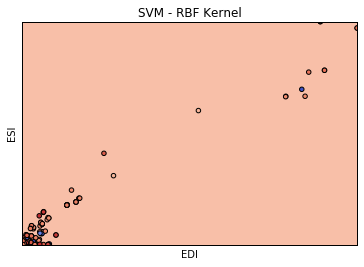

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm

combined_train_features = pd.read_csv('data/combined-pe-features-apt-reduced.csv')
train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-apt.csv')

#X = combined_train_features.iloc[:,1:]
y = train_labels['label']
h = 10.0  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter

print("RBF SVM:")
X = combined_train_features.iloc[:,1:3]
#X.head()

rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X.iloc[:,0].min() - 1, X.iloc[:,0].max() + 1
y_min, y_max = X.iloc[:,1].min() - 1, X.iloc[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = rbf_svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('EDI')
plt.ylabel('ESI')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('SVM - RBF Kernel')

plt.show()

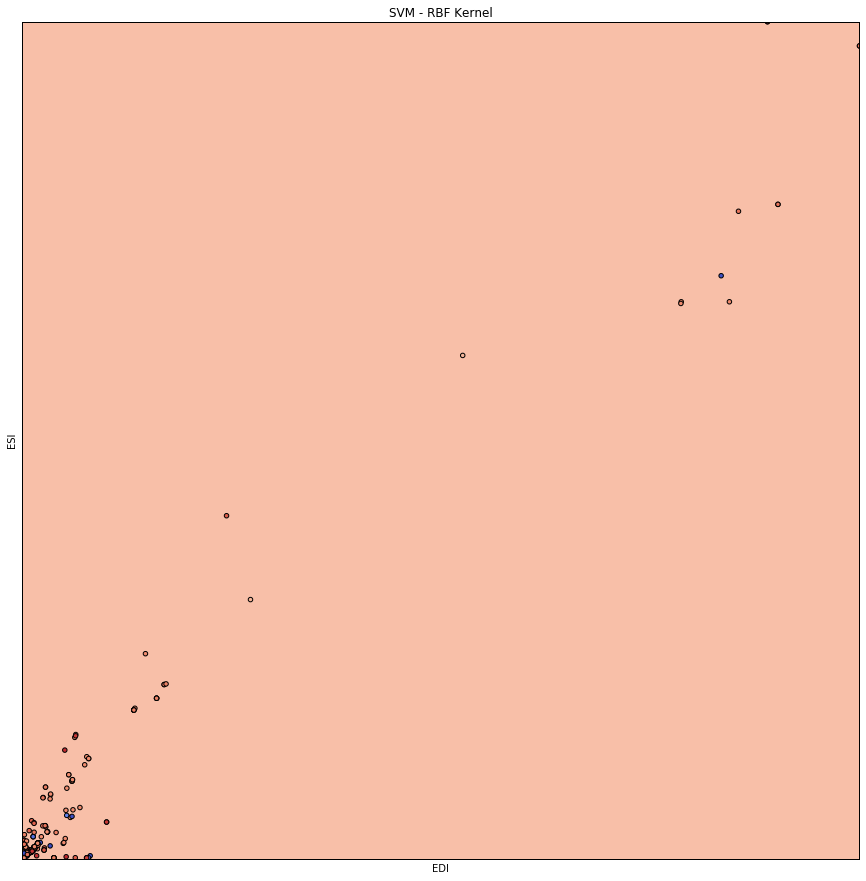

In [8]:
plt.figure(figsize=(15,15))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('EDI')
plt.ylabel('ESI')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('SVM - RBF Kernel')

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm

combined_train_features = pd.read_csv('data/combined-pe-features-apt-reduced.csv')
train_labels = pd.read_csv('data/sorted-pe-coff-train-labels-apt.csv')

#X = combined_train_features.iloc[:,1:]
y = train_labels['label']
h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter

print("Linear SVM")
X = combined_train_features.iloc[:,1:3]
svc = svm.SVC(kernel='linear', C=C).fit(X, y)

print("RBF SVM")
X = combined_train_features.iloc[:,1:3]
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)

print("Poly SVM")
X = combined_train_features.iloc[:,1:3]
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)

print("Linear SVM 2")
X = combined_train_features.iloc[:,1:3]
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])


plt.show()

Linear SVM


In [ ]:
help(plt)

In [ ]:
# Lets do some plots and have look.
plt.figure(figsize=(15,15))
plt.xlabel("Vertex Count")
plt.ylabel("Edge Count")
xa = np.array(X['vertex_count'])
xb = np.array(X['edge_count'])
ya = np.array(y)
plt.scatter(xa,xb,c=ya,cmap='brg')

# Lets do some plots and have look.
plt.figure(figsize=(15,15))
plt.xlabel("EDX Register")
plt.ylabel("Malware Class")
xa = np.array(X['edx'])
xb = np.array(X['esi'])
ya = np.array(y)
plt.scatter(xa,ya,c=ya,cmap='brg')

plt.figure(figsize=(15,15))
plt.xlabel("EDX Register")
plt.ylabel("ESI Register")
plt.scatter(xa,xb,c=ya,cmap='brg')

In [ ]:
# Fix ASM feature file_name values.

in_file = open('data/sorted-pe-asm-features-vs251.csv', 'r')
in_lines = in_file.readlines()
in_file.close()

for line in in_lines:
    idx = line.find('.pe')
    if idx > 0:
        # TODO:

In [ ]:
# TEST CODE ONLY:

In [ ]:
# 500 estimators 

clf1 = ExtraTreesClassifier(n_estimators=500, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-extratrees-vs264-500.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs264-500.txt')

In [ ]:
# 1000 estimators 
# memory/kernel fail
clf1 = ExtraTreesClassifier(n_estimators=1000, max_features=None, min_samples_leaf=1, min_samples_split=9, n_jobs=4, criterion='gini')
start = time()
pred1 = run_prediction_cv(X, y, clf1, 10)
print(" ")
print("Classification report:")
print_classification_report(y, pred1, 'classification-report-extratrees-vs264-1000.txt')
print("score = {:.3f}".format(accuracy_score(y, pred1)))
print(" ")
print("ExtraTreesClassifier took {:.2f} minutes.".format(((time() - start) / 60)))
cm = confusion_matrix(y, pred1)
write_confusion_matrix(cm, 'confusion-matrix-xtratrees-vs264-1000.txt')